In [1]:
# Plot style
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Latin Modern"
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.right"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["ytick.major.size"] = 3

In [2]:
def n_total_tokens(row):
    return len(row["changes"])

def n_changed_tokens(row):
    changed_token_counter = 0
    for change in row["changes"]:
        if change[0] != change[1]:
            changed_token_counter += 1
    return changed_token_counter

def fraction_changed_tokens(row):
    if row["n_total_tokens"] == 0:
        return 0
    return row["n_changed_tokens"] / row["n_total_tokens"]

def amega_n_total_tokens(row, cases_df):
    return row["n_total_tokens"] + cases_df.loc[cases_df["case_id"] == row["case_id"], "n_total_tokens"].values[0]

def amega_n_changed_tokens(row, cases_df):
    return row["n_changed_tokens"] + cases_df.loc[cases_df["case_id"] == row["case_id"], "n_changed_tokens"].values[0]

def amega_per_question_total_score(row, criteria_df):
    criteria = criteria_df.loc[(criteria_df["case_id"] == row["case_id"]) & (criteria_df["question_id"] == row["question_id"])]
    return criteria["criteria_score_possible"].sum()

def amega_per_question_achieved_score(row, criteria_df, majority_vote_column):
    criteria = criteria_df.loc[(criteria_df["case_id"] == row["case_id"]) & (criteria_df["question_id"] == row["question_id"])]
    criteria_achieved = criteria[row[majority_vote_column]]
    return criteria_achieved["criteria_score_possible"].sum()


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import AutoConfig, AutoTokenizer
from huggingface_hub import hf_hub_download
from safetensors import safe_open
import json

# Download only the embedding weights
model_id = "mistralai/Mistral-Large-Instruct-2411"
tokenizer = AutoTokenizer.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)

vocab_size = config.vocab_size
hidden_size = config.hidden_size
embedder = nn.Embedding(vocab_size, hidden_size)

index_path = hf_hub_download(repo_id=model_id, filename="model.safetensors.index.json")
with open(index_path, "r") as f:
    index_data = json.load(f)
embedding_weight_key = "model.embed_tokens.weight"
embedding_weights_file = index_data["weight_map"][embedding_weight_key]
weights_path = hf_hub_download(repo_id=model_id, filename=embedding_weights_file)
with safe_open(weights_path, framework="pt", device="cpu") as f:
    embedding_tensor = f.get_tensor(embedding_weight_key)

embedder.load_state_dict({"weight": embedding_tensor})


def mean_cosine_similarity(row):
    n_words = 0
    cosine_sum = 0
    for original, synonym in row["changes"]:
        if original == synonym:
            n_words += 1
            cosine_sum += 1
        else:
            original_input_ids = tokenizer(original, add_special_tokens=False, return_tensors="pt")["input_ids"]
            synonym_input_ids = tokenizer(synonym, add_special_tokens=False, return_tensors="pt")["input_ids"]
            
            # Ensure input_ids are integers (Long tensors)
            original_input_ids = original_input_ids.long()
            synonym_input_ids = synonym_input_ids.long()

            with torch.no_grad():
                original_embeddings = embedder(original_input_ids).mean(dim=1).flatten()
                synonym_embeddings = embedder(synonym_input_ids).mean(dim=1).flatten()

                cosine = F.cosine_similarity(original_embeddings, synonym_embeddings, dim=0).item()
                cosine_sum += cosine
                n_words += 1

    if n_words == 0:
        return 1
    
    return cosine_sum / n_words

def amega_mean_cosine_similarity(row, cases_df):
    case_changes = cases_df.loc[cases_df["case_id"] == row["case_id"], "changes"].values[0]
    n_words = 0
    cosine_sum = 0
    for original, synonym in case_changes:
        if original == synonym:
            n_words += 1
            cosine_sum += 1
        else:
            original_input_ids = tokenizer(original, add_special_tokens=False, return_tensors="pt")["input_ids"]
            synonym_input_ids = tokenizer(synonym, add_special_tokens=False, return_tensors="pt")["input_ids"]
            
            # Ensure input_ids are integers (Long tensors)
            original_input_ids = original_input_ids.long()
            synonym_input_ids = synonym_input_ids.long()
            
            with torch.no_grad():
                original_embeddings = embedder(original_input_ids).mean(dim=1).flatten()
                synonym_embeddings = embedder(synonym_input_ids).mean(dim=1).flatten()

                cosine = F.cosine_similarity(original_embeddings, synonym_embeddings, dim=0).item()
                cosine_sum += cosine
                n_words += 1
    
    for original, synonym in row["changes"]:
        if original == synonym:
            n_words += 1
            cosine_sum += 1
        else:
            original_input_ids = tokenizer(original, add_special_tokens=False, return_tensors="pt")["input_ids"]
            synonym_input_ids = tokenizer(synonym, add_special_tokens=False, return_tensors="pt")["input_ids"]
            
            # Ensure input_ids are integers (Long tensors)
            original_input_ids = original_input_ids.long()
            synonym_input_ids = synonym_input_ids.long()
            
            with torch.no_grad():
                original_embeddings = embedder(original_input_ids).mean(dim=1).flatten()
                synonym_embeddings = embedder(synonym_input_ids).mean(dim=1).flatten()

                cosine = F.cosine_similarity(original_embeddings, synonym_embeddings, dim=0).item()
                cosine_sum += cosine
                n_words += 1

    if n_words == 0:
        return 1
    return cosine_sum / n_words


In [4]:
from haystack.components.evaluators import SASEvaluator
from haystack.utils import ComponentDevice
import evaluate

# Initialize evaluators
squad_evaluator = evaluate.load("squad")
sas_evaluator = SASEvaluator(device=ComponentDevice.from_str("mps"))
sas_evaluator.warm_up()


def exact_match_score(row, pred_column):
    result = squad_evaluator.compute(
        predictions=[{"id": "id", "prediction_text": row[pred_column]}],
        references=[{"id": "id", "answers": row["answers"]}]
    )["exact_match"]
    if int(result) == 100:
        return 1
    return 0

def f1_score(row, pred_column):
    result = squad_evaluator.compute(
        predictions=[{"id": "id", "prediction_text": row[pred_column]}],
        references=[{"id": "id", "answers": row["answers"]}]
    )["f1"]
    return result

def sas_score(row, pred_column):
    sas_eval = sas_evaluator.run(row["answers"]["text"], [row[pred_column]] * len(row["answers"]["text"]))
    return max(sas_eval["individual_scores"])

# Data Preprocessing
## MMLU

In [5]:
import json
import pandas as pd

with open("../../data/mmlu/lexical/llm_synonym_perturbation.json") as file:
    data = json.load(file)

mmlu_data_df = pd.DataFrame(data["data"])
mmlu_data_df["n_changed_tokens"] = mmlu_data_df.apply(n_changed_tokens, axis=1)
mmlu_data_df["n_total_tokens"] = mmlu_data_df.apply(n_total_tokens, axis=1)
mmlu_data_df["fraction_changed_tokens"] = mmlu_data_df.apply(fraction_changed_tokens, axis=1)
mmlu_data_df["mean_cosine_similarity"] = mmlu_data_df.apply(mean_cosine_similarity, axis=1)

with open("../../results/mistral-large-instruct/mmlu/original.json") as file:
    mmlu_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/mistral-large-instruct/mmlu/lexical/llm_synonym.json") as file:
    mmlu_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

mmlu_data_df["correct_original"] = mmlu_original_performance_df["answer"] == mmlu_original_performance_df["prediction"]
mmlu_data_df["correct_synonym"] = mmlu_synonym_performance_df["answer"] == mmlu_synonym_performance_df["prediction"]


## SQuAD

In [6]:
from datasets import load_dataset

with open("../../data/squad/lexical/llm_synonym_perturbation.json") as file:
    data = json.load(file)

squad_data_df = pd.DataFrame(data["data"])
squad_data_df["answers"] = load_dataset("rajpurkar/squad", split="validation").shuffle(seed=77).select(range(1000)).to_pandas()["answers"]
squad_data_df["n_changed_tokens"] = squad_data_df.apply(n_changed_tokens, axis=1)
squad_data_df["n_total_tokens"] = squad_data_df.apply(n_total_tokens, axis=1)
squad_data_df["fraction_changed_tokens"] = squad_data_df.apply(fraction_changed_tokens, axis=1)
squad_data_df["mean_cosine_similarity"] = squad_data_df.apply(mean_cosine_similarity, axis=1)

with open("../../results/mistral-large-instruct/squad/original.json") as file:
    squad_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/mistral-large-instruct/squad/lexical/llm_synonym.json") as file:
    squad_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

squad_data_df["original_prediction"] = squad_original_performance_df["prediction"]
squad_data_df["synonym_prediction"] = squad_synonym_performance_df["prediction"]

squad_data_df["original_exact_match"] = squad_data_df.apply(exact_match_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_exact_match"] = squad_data_df.apply(exact_match_score, axis=1, pred_column="synonym_prediction")

squad_data_df["original_f1"] = squad_data_df.apply(f1_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_f1"] = squad_data_df.apply(f1_score, axis=1, pred_column="synonym_prediction")

squad_data_df["original_sas"] = squad_data_df.apply(sas_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_sas"] = squad_data_df.apply(sas_score, axis=1, pred_column="synonym_prediction")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## AMEGA

In [7]:
with open("../../data/amega/lexical/llm_synonym_perturbation_cases.json") as file:
    amega_cases_data_df = pd.DataFrame(json.load(file)["data"])

with open("../../data/amega/lexical/llm_synonym_perturbation_questions.json") as file:
    amega_questions_data_df = pd.DataFrame(json.load(file)["data"])
criteria_df = pd.read_csv("../../AMEGA-benchmark/data/criteria.csv", sep=";")

amega_cases_data_df["n_changed_tokens"] = amega_cases_data_df.apply(n_changed_tokens, axis=1)
amega_cases_data_df["n_total_tokens"] = amega_cases_data_df.apply(n_total_tokens, axis=1)

amega_questions_data_df["n_changed_tokens"] = amega_questions_data_df.apply(n_changed_tokens, axis=1)
amega_questions_data_df["n_total_tokens"] = amega_questions_data_df.apply(n_total_tokens, axis=1)
amega_questions_data_df["n_changed_tokens"] = amega_questions_data_df.apply(amega_n_changed_tokens, axis=1, cases_df=amega_cases_data_df)
amega_questions_data_df["n_total_tokens"] = amega_questions_data_df.apply(amega_n_total_tokens, axis=1, cases_df=amega_cases_data_df)
amega_questions_data_df["fraction_changed_tokens"] = amega_questions_data_df.apply(fraction_changed_tokens, axis=1)
amega_questions_data_df["mean_cosine_similarity"] = amega_questions_data_df.apply(amega_mean_cosine_similarity, axis=1, cases_df=amega_cases_data_df)

with open("../../results/mistral-large-instruct/amega/original_v3.json") as file:
    amega_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/mistral-large-instruct/amega/lexical/llm_synonym_v3.json") as file:
    amega_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

amega_questions_data_df["majority_vote_original"] = amega_original_performance_df["majority_vote"]
amega_questions_data_df["majority_vote_synonym"] = amega_synonym_performance_df["majority_vote"]

amega_questions_data_df["total_score"] = amega_questions_data_df.apply(amega_per_question_total_score, axis=1, criteria_df=criteria_df)
amega_questions_data_df["achieved_score_original"] = amega_questions_data_df.apply(amega_per_question_achieved_score, axis=1, criteria_df=criteria_df, majority_vote_column="majority_vote_original")
amega_questions_data_df["achieved_score_synonym"] = amega_questions_data_df.apply(amega_per_question_achieved_score, axis=1, criteria_df=criteria_df, majority_vote_column="majority_vote_synonym")
amega_questions_data_df["performance_original"] = amega_questions_data_df["achieved_score_original"] / amega_questions_data_df["total_score"]
amega_questions_data_df["performance_synonym"] = amega_questions_data_df["achieved_score_synonym"] / amega_questions_data_df["total_score"]

# Performance difference by fraction of changed tokens

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'


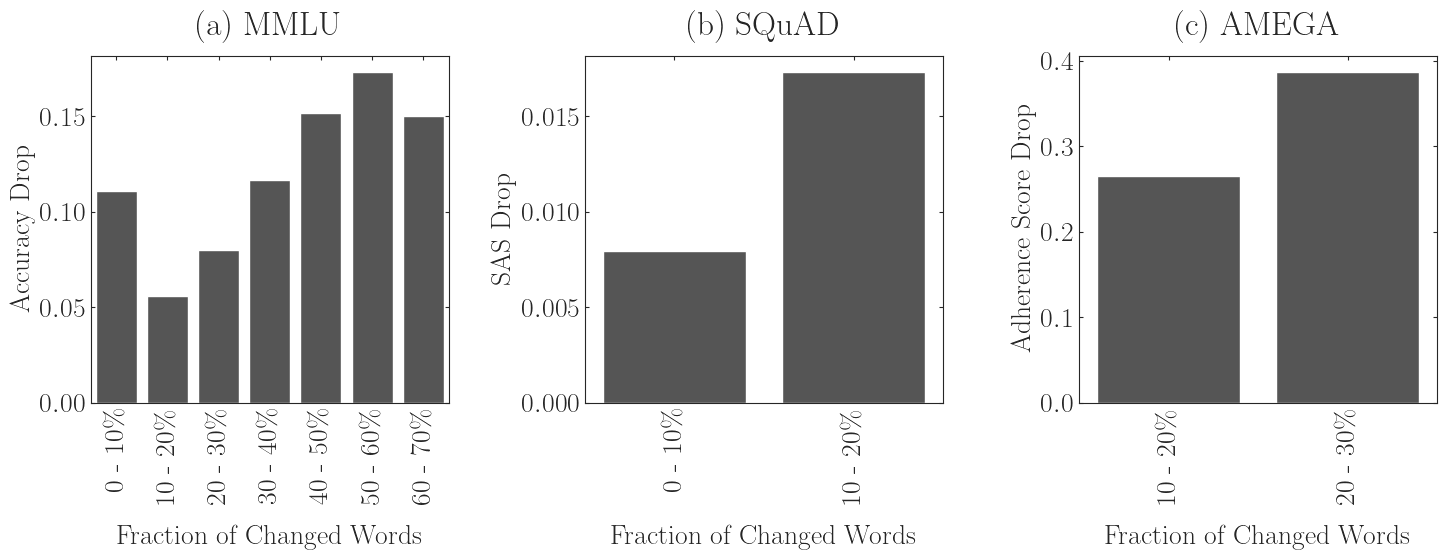

In [8]:
dfs = {
    "(a) MMLU": mmlu_data_df,
    "(b) SQuAD": squad_data_df,
    "(c) AMEGA": amega_questions_data_df
}

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ["0 - 10\%", "10 - 20\%", "20 - 30\%", "30 - 40\%", "40 - 50\%", "50 - 60\%", "60 - 70\%", "70 - 80\%", "80 - 90\%", "90 - 100\%"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i, (label, df) in enumerate(dfs.items()):
    df["fraction_bin"] = pd.cut(
        df["fraction_changed_tokens"],
        bins=bins,
        labels=labels,
        right=False
    )
    bin_counts = df["fraction_bin"].value_counts().reindex(labels)

    if label == "(a) MMLU":
        performance_column_original = "correct_original"
        performance_column_synonym = "correct_synonym"
    elif label == "(b) SQuAD":
        performance_column_original = "original_sas"
        performance_column_synonym = "synonym_sas"
    elif label == "(c) AMEGA":
        performance_column_original = "achieved_score_original"
        performance_column_synonym = "achieved_score_synonym"

    bin_accuracy_original = df.groupby("fraction_bin")[performance_column_original].mean().reset_index()
    bin_accuracy_synonym = df.groupby("fraction_bin")[performance_column_synonym].mean().reset_index()

    bin_accuracy_original["performance_drop"] = bin_accuracy_original[performance_column_original] - bin_accuracy_synonym[performance_column_synonym]
    
    # Filter bins where bin_count > 10
    valid_bins = bin_counts[bin_counts > 10].index
    filtered_data = bin_accuracy_original[bin_accuracy_original["fraction_bin"].isin(valid_bins)]
    filtered_data["fraction_bin"] = filtered_data["fraction_bin"].cat.remove_unused_categories()
    
    sns.barplot(x="fraction_bin", y="performance_drop", data=filtered_data, color="#555555", ax=axes[i])
    
    axes[i].set_title(label, pad=15)
    axes[i].set_xlabel("Fraction of Changed Words", labelpad=15)
    if i == 0:
        axes[i].set_ylabel("Accuracy Drop")
    elif i == 1:
        axes[i].set_ylabel("SAS Drop")
    else:
        axes[i].set_ylabel("Adherence Score Drop")
    axes[i].set_xticks(range(len(filtered_data)))
    axes[i].set_xticklabels(filtered_data["fraction_bin"], rotation=90, ha="center")

plt.tight_layout()
plt.savefig("../../figs/lexical_changed_tokens_performance_drop.pdf", dpi=300)
plt.show()



# Performance difference by mean cosine similarity

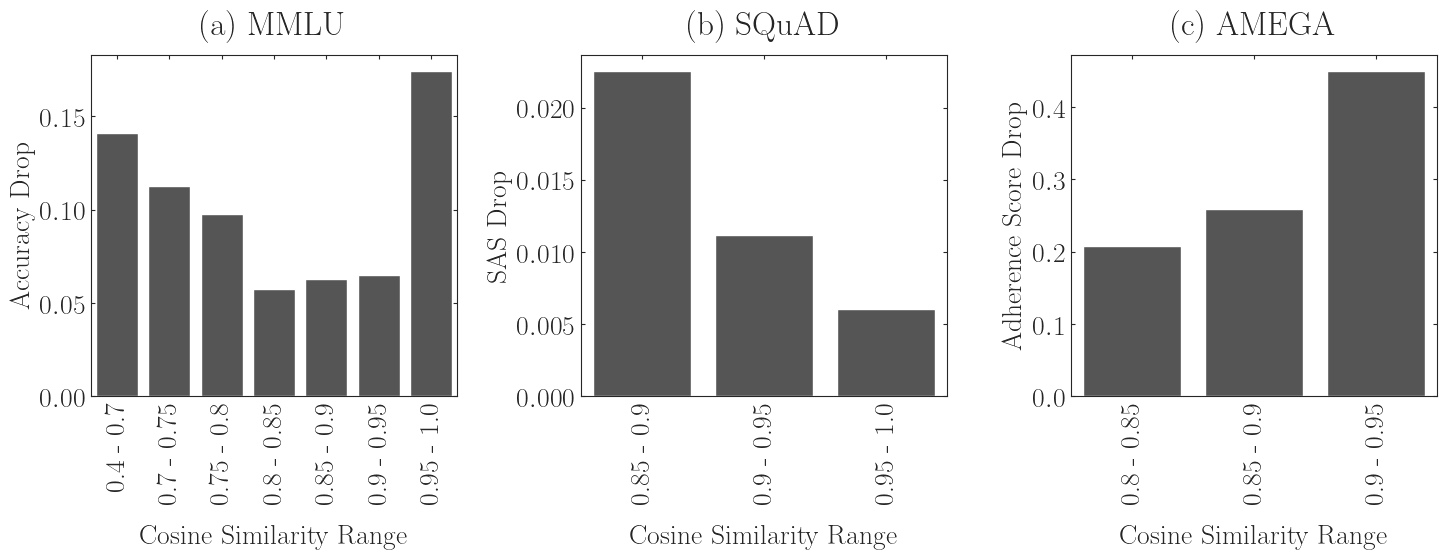

In [9]:
cosine_bins = [0.4, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
cosine_labels = ["0.4 - 0.7", "0.7 - 0.75", "0.75 - 0.8", "0.8 - 0.85", "0.85 - 0.9", "0.9 - 0.95", "0.95 - 1.0"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i, (label, df) in enumerate(dfs.items()):
    df["cosine_bin"] = pd.cut(
        df["mean_cosine_similarity"],
        bins=cosine_bins,
        labels=cosine_labels,
        right=False
    )
    bin_counts = df["cosine_bin"].value_counts().reindex(cosine_labels)

    if label == "(a) MMLU":
        performance_column_original = "correct_original"
        performance_column_synonym = "correct_synonym"
    elif label == "(b) SQuAD":
        performance_column_original = "original_sas"
        performance_column_synonym = "synonym_sas"
    elif label == "(c) AMEGA":
        performance_column_original = "achieved_score_original"
        performance_column_synonym = "achieved_score_synonym"

    bin_accuracy_original = df.groupby("cosine_bin", observed=True)[performance_column_original].mean().reset_index()
    bin_accuracy_synonym = df.groupby("cosine_bin", observed=True)[performance_column_synonym].mean().reset_index()

    bin_accuracy_original["performance_drop"] = bin_accuracy_original[performance_column_original] - bin_accuracy_synonym[performance_column_synonym]
    
    # Filter bins where bin_count > 10
    valid_bins = bin_counts[bin_counts > 10].index
    filtered_data = bin_accuracy_original[bin_accuracy_original["cosine_bin"].isin(valid_bins)].copy()
    filtered_data["cosine_bin"] = filtered_data["cosine_bin"].cat.remove_unused_categories()
    
    sns.barplot(x="cosine_bin", y="performance_drop", data=filtered_data, color="#555555", ax=axes[i])
    bin_counts = bin_counts[bin_counts > 10]
    
    axes[i].set_title(label, pad=15)
    axes[i].set_xlabel("Cosine Similarity Range", labelpad=15)
    if i == 0:
        axes[i].set_ylabel("Accuracy Drop")
    elif i == 1:
        axes[i].set_ylabel("SAS Drop")
    else:
        axes[i].set_ylabel("Adherence Score Drop")
    axes[i].set_xticks(range(len(filtered_data)))
    axes[i].set_xticklabels(filtered_data["cosine_bin"], rotation=90, ha="center")

plt.tight_layout()
plt.savefig("../../figs/lexical_cosine_similarity_performance_drop.pdf", dpi=300)
plt.show()